Запуск оптимизированной симуляции...

Обработка вероятности возгорания: 2e-05
  График для окрестности фон Неймана...


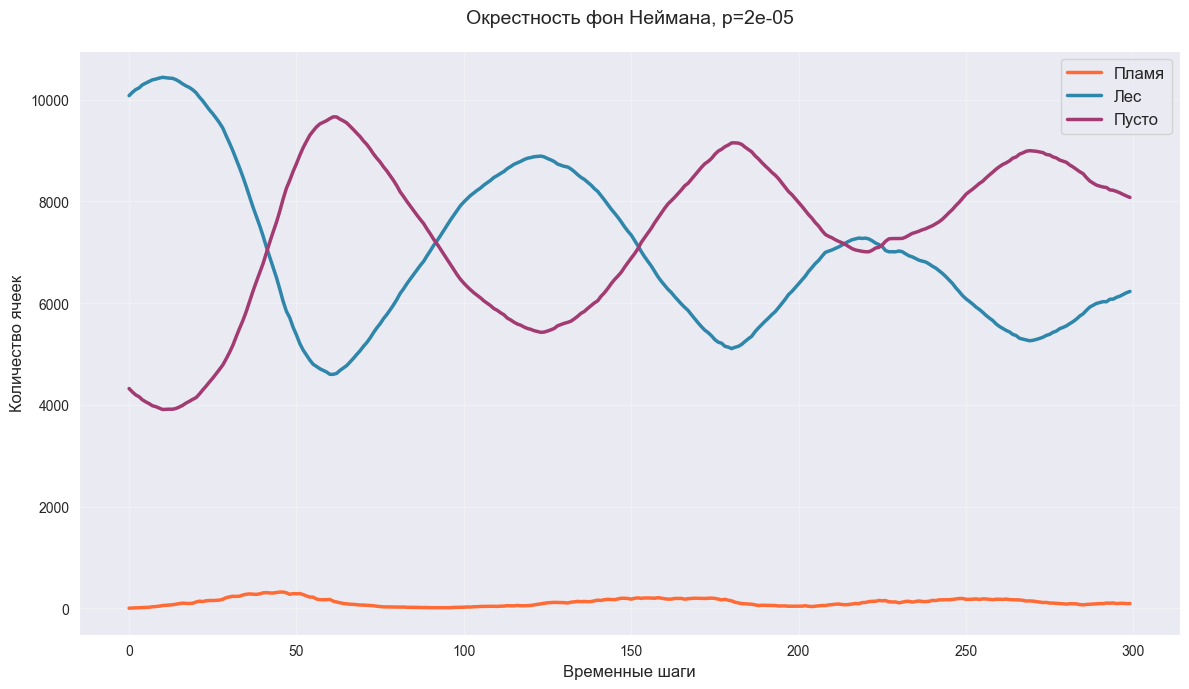

  График для окрестности Мура...


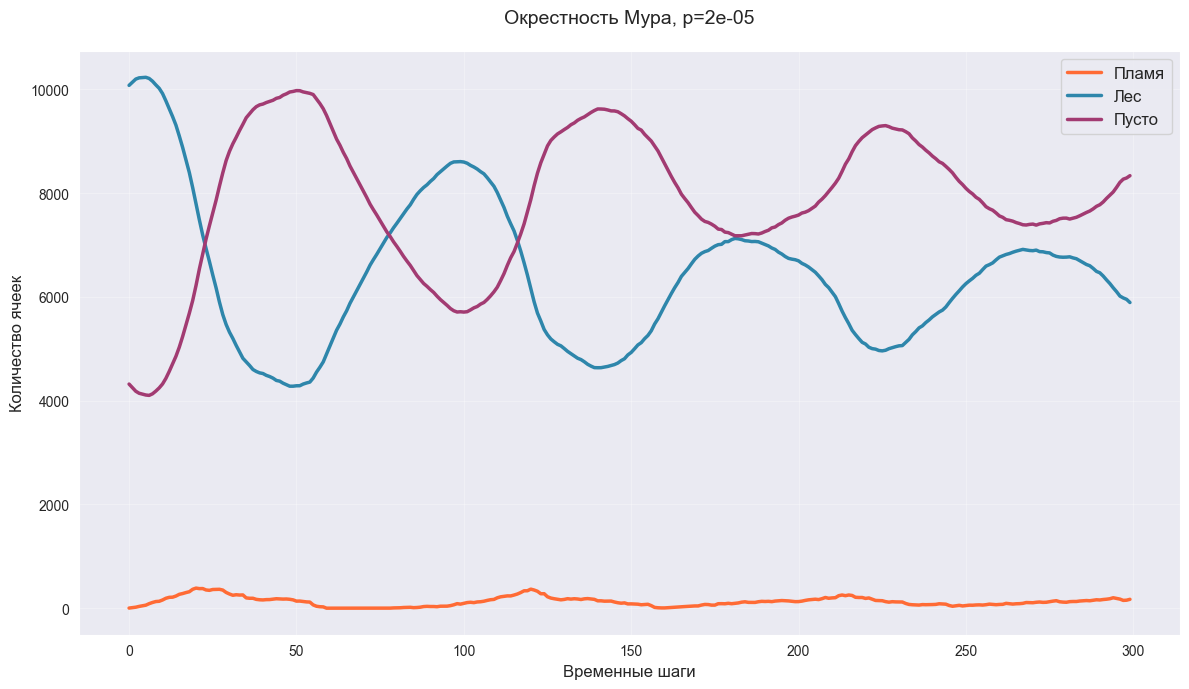

  Анимация для фон Неймана...
Анимация сохранена: von_neumann_fire_2e-05.gif
  Анимация для Мура...
Анимация сохранена: moore_fire_2e-05.gif

Обработка вероятности возгорания: 3e-05
  График для окрестности фон Неймана...


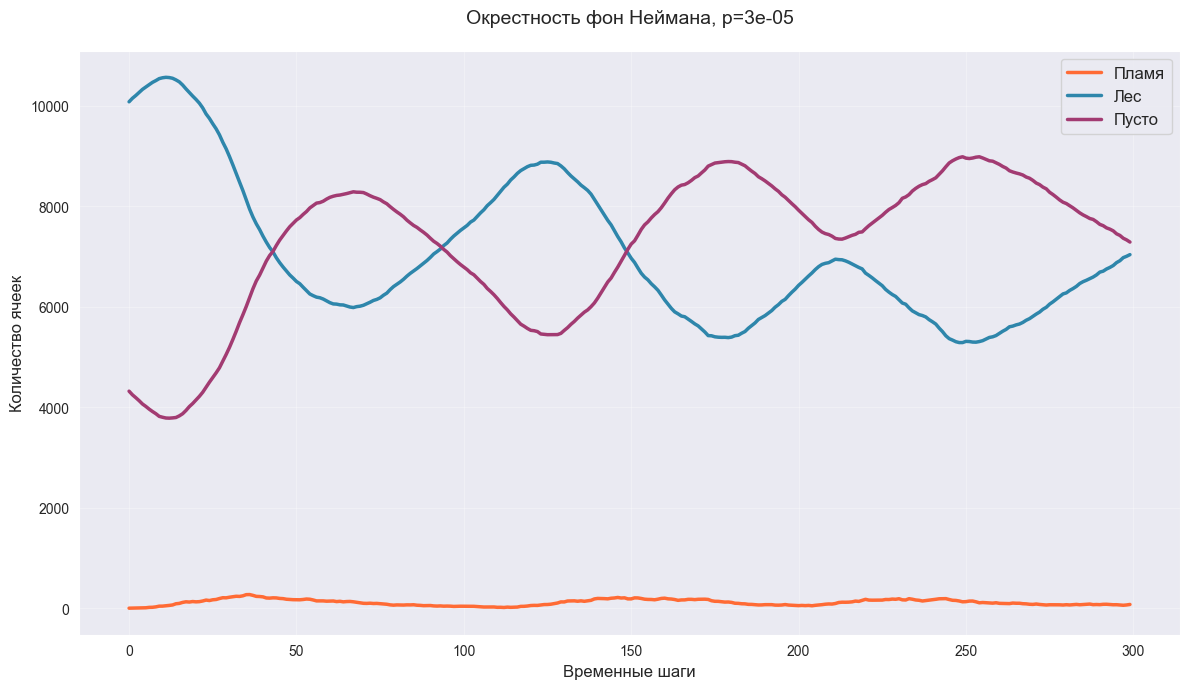

  График для окрестности Мура...


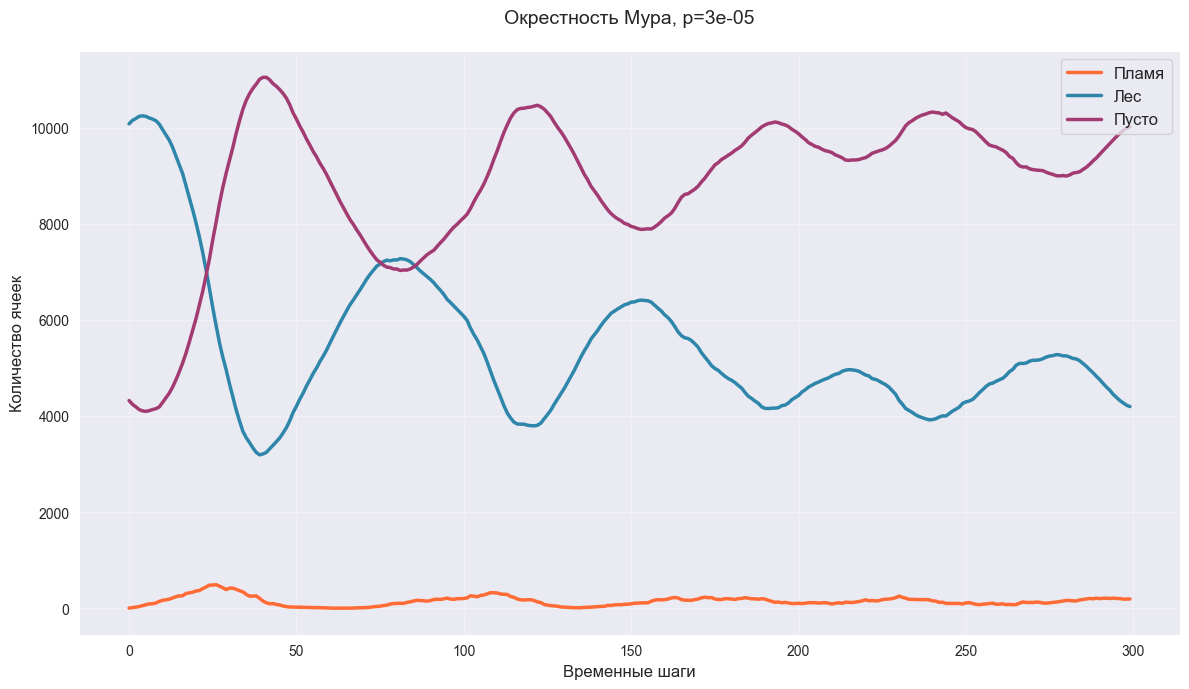

  Анимация для фон Неймана...
Анимация сохранена: von_neumann_fire_3e-05.gif
  Анимация для Мура...
Анимация сохранена: moore_fire_3e-05.gif

Обработка вероятности возгорания: 4e-05
  График для окрестности фон Неймана...


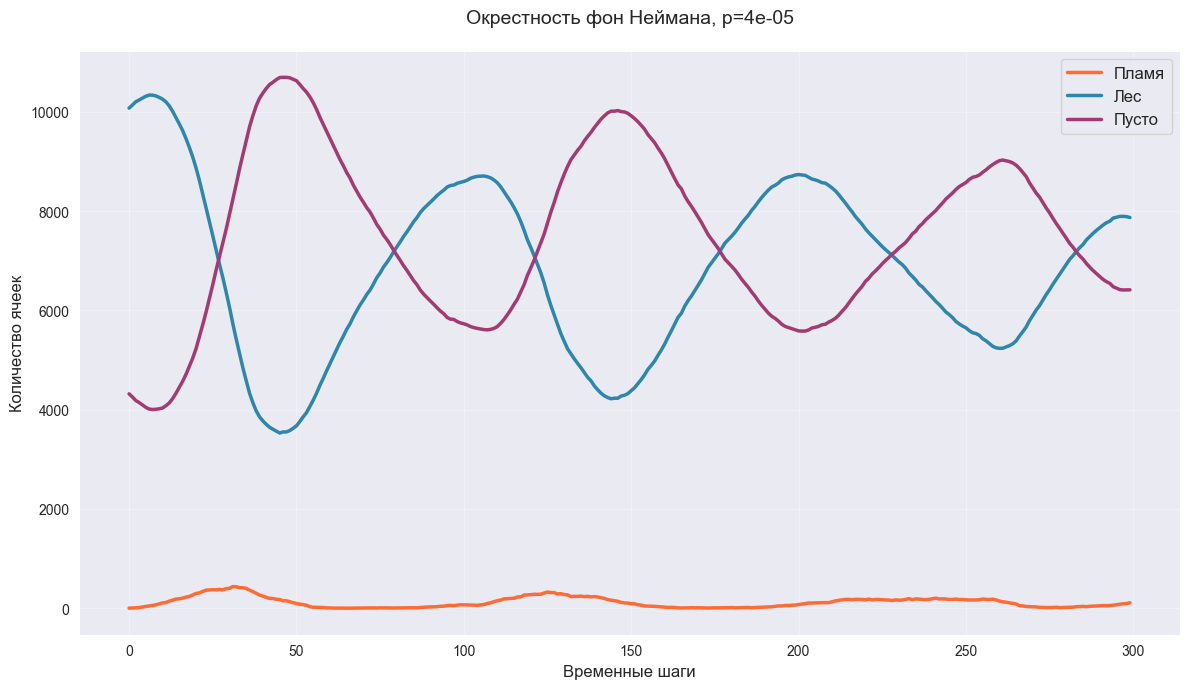

  График для окрестности Мура...


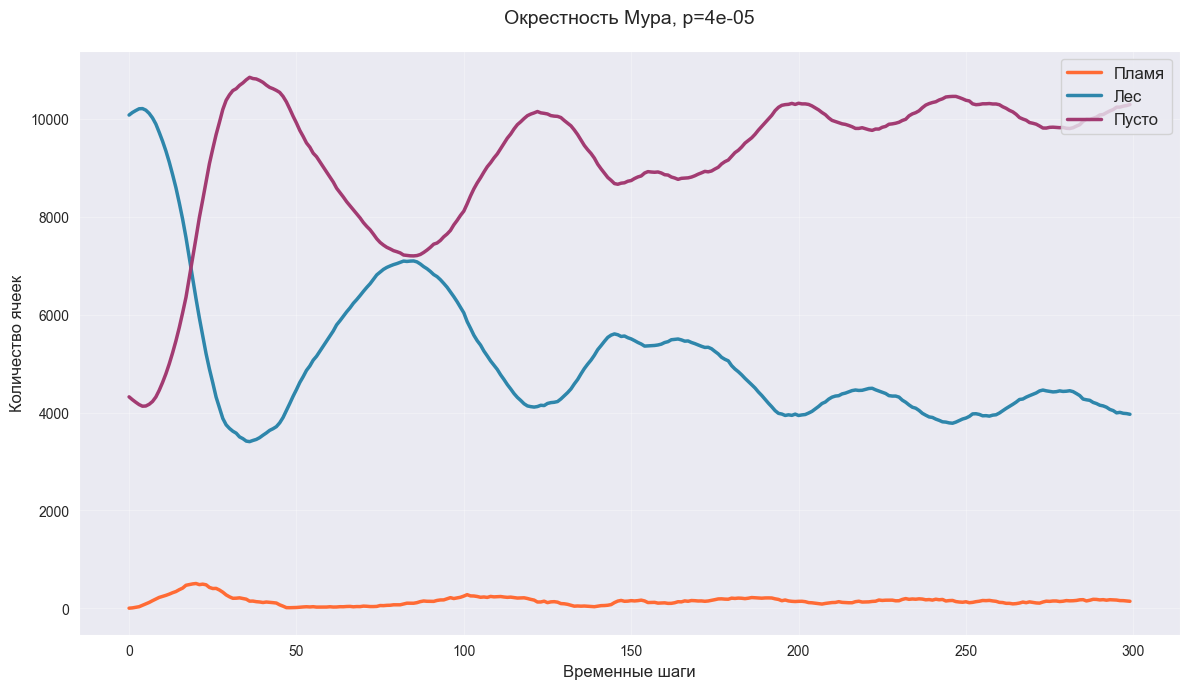

  Анимация для фон Неймана...
Анимация сохранена: von_neumann_fire_4e-05.gif
  Анимация для Мура...
Анимация сохранена: moore_fire_4e-05.gif

Симуляция завершена! Создано:
- 6 графиков (3 вероятности × 2 типа окрестностей)
- 6 GIF-анимаций (3 вероятности × 2 типа окрестностей)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from enum import IntEnum
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from scipy import ndimage

class GridType(IntEnum):
    VON_NEUMANN = 0
    MOORE = 1

class CellState(IntEnum):
    BARE = 0
    BURNING = 1
    FOREST = 2

def generate_grid(rows, cols):
    return np.zeros((rows, cols), dtype=np.int8)

def setup_initial_config(grid, density, initial_fires, random_gen):
    rows, cols = grid.shape
    total_cells = rows * cols
    forest_cells = int(density * total_cells)

    positions = random_gen.choice(total_cells, forest_cells, replace=False)
    grid.flat[positions] = CellState.FOREST

    fire_positions = random_gen.choice(positions, initial_fires, replace=False)
    grid.flat[fire_positions] = CellState.BURNING

    return grid

def get_neighborhood_kernel(neighborhood_type):
    if neighborhood_type == GridType.VON_NEUMANN:
        return np.array([[0, 1, 0],
                         [1, 0, 1],
                         [0, 1, 0]])
    else:
        return np.array([[1, 1, 1],
                         [1, 0, 1],
                         [1, 1, 1]])

def evolve_grid_fast(grid, neighborhood_type, random_gen, ignite_chance, growth_chance):
    kernel = get_neighborhood_kernel(neighborhood_type)

    burning_neighbors = ndimage.convolve(
        (grid == CellState.BURNING).astype(int),
        kernel,
        mode='constant'
    )

    new_grid = grid.copy()

    burning_mask = grid == CellState.BURNING
    forest_mask = grid == CellState.FOREST
    bare_mask = grid == CellState.BARE

    forest_burns = (burning_neighbors > 0) | (random_gen.random(grid.shape) < ignite_chance)
    new_grid[forest_mask & forest_burns] = CellState.BURNING

    new_grid[burning_mask] = CellState.BARE

    can_grow = (burning_neighbors == 0) & (random_gen.random(grid.shape) < growth_chance)
    new_grid[bare_mask & can_grow] = CellState.FOREST

    return new_grid

class SimulationMetrics:
    def __init__(self):
        self.time_steps = []
        self.burning_counts = []
        self.forest_counts = []
        self.empty_counts = []

    def record_state(self, time_step, grid):
        self.time_steps.append(time_step)
        self.burning_counts.append((grid == CellState.BURNING).sum())
        self.forest_counts.append((grid == CellState.FOREST).sum())
        self.empty_counts.append((grid == CellState.BARE).sum())

def run_simulation_fast(initial_grid, n_type, rand_gen, ignite_rate, growth_rate, duration):
    metrics = SimulationMetrics()
    current_grid = initial_grid.copy()

    for step in range(duration):
        metrics.record_state(step, current_grid)
        current_grid = evolve_grid_fast(current_grid, n_type, rand_gen, ignite_rate, growth_rate)

    return metrics

def visualize_metrics(metrics, plot_title):
    plt.figure(figsize=(12, 7))

    plt.plot(metrics.time_steps, metrics.burning_counts,
             color='#FF6B35', linewidth=2.5, label='Пламя')
    plt.plot(metrics.time_steps, metrics.forest_counts,
             color='#2E86AB', linewidth=2.5, label='Лес')
    plt.plot(metrics.time_steps, metrics.empty_counts,
             color='#A23B72', linewidth=2.5, label='Пусто')

    plt.legend(fontsize=12, loc='upper right')
    plt.title(plot_title, fontsize=14, pad=20)
    plt.xlabel('Временные шаги', fontsize=12)
    plt.ylabel('Количество ячеек', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_animation_fast(initial_grid, n_type, rand_gen, ignite_rate, growth_rate,
                         duration, frame_interval=50, output_file="forest_fire_simulation.gif"):

    fig, ax = plt.subplots(figsize=(8, 8))
    custom_palette = ListedColormap(['#4A4A4A', '#FF9505', '#00743F'])

    current_state = initial_grid.copy()
    image = ax.imshow(current_state, cmap=custom_palette)
    time_label = ax.set_title("")

    ax.set_xlabel("Ширина", fontsize=11)
    ax.set_ylabel("Высота", fontsize=11)

    def update_frame(time_step):
        nonlocal current_state
        ax.set_title(f"Шаг времени: {time_step}", fontsize=13)
        image.set_array(current_state)
        current_state = evolve_grid_fast(current_state, n_type, rand_gen, ignite_rate, growth_rate)
        return [image, time_label]

    frames_to_save = min(duration, 150)
    step = max(1, duration // frames_to_save)

    anim = animation.FuncAnimation(fig, update_frame, frames=range(0, duration, step),
                                 interval=frame_interval, blit=True)
    anim.save(output_file, writer='pillow', dpi=80)
    plt.close()
    print(f"Анимация сохранена: {output_file}")

grid_width, grid_height = 120, 120
forest_density = 0.7
initial_fires_count = 2
growth_probability = 0.015
ignition_probabilities = [2e-5, 3e-5, 4e-5]
simulation_duration = 300
animation_duration = 150
random_seed = 1097

print("Запуск оптимизированной симуляции...")

for i, ignition_prob in enumerate(ignition_probabilities):
    print(f"\nОбработка вероятности возгорания: {ignition_prob}")

    random_state = np.random.RandomState(random_seed + i)
    grid = generate_grid(grid_height, grid_width)
    grid = setup_initial_config(grid, forest_density, initial_fires_count, random_state)


    print("  График для окрестности фон Неймана...")
    results_vn = run_simulation_fast(grid.copy(), GridType.VON_NEUMANN, random_state,
                                   ignition_prob, growth_probability, simulation_duration)
    visualize_metrics(results_vn, f'Окрестность фон Неймана, p={ignition_prob}')


    print("  График для окрестности Мура...")
    results_moore = run_simulation_fast(grid.copy(), GridType.MOORE, random_state,
                                      ignition_prob, growth_probability, simulation_duration)
    visualize_metrics(results_moore, f'Окрестность Мура, p={ignition_prob}')

    print("  Анимация для фон Неймана...")
    create_animation_fast(grid.copy(), GridType.VON_NEUMANN, random_state,
                         ignition_prob, growth_probability, animation_duration,
                         output_file=f"von_neumann_fire_{ignition_prob}.gif")

    print("  Анимация для Мура...")
    create_animation_fast(grid.copy(), GridType.MOORE, random_state,
                         ignition_prob, growth_probability, animation_duration,
                         output_file=f"moore_fire_{ignition_prob}.gif")

print("\nСимуляция завершена! Создано:")
print("- 6 графиков (3 вероятности × 2 типа окрестностей)")
print("- 6 GIF-анимаций (3 вероятности × 2 типа окрестностей)")